In [0]:
#Helpers
import numpy as np

def batch(inputs, max_sequence_length=None):
    """
    Args:
        inputs:
            list of sentences (integer lists)
        max_sequence_length:
            integer specifying how large should `max_time` dimension be.
            If None, maximum sequence length would be used
    
    Outputs:
        inputs_time_major:
            input sentences transformed into time-major matrix 
            (shape [max_time, batch_size]) padded with 0s
        sequence_lengths:
            batch-sized list of integers specifying amount of active 
            time steps in each input sequence
    """
    
    sequence_lengths = [len(seq) for seq in inputs]
    batch_size = len(inputs)
    
    if max_sequence_length is None:
        max_sequence_length = max(sequence_lengths)
    
    inputs_batch_major = np.zeros(shape=[batch_size, max_sequence_length], dtype=np.int32) # == PAD
    
    for i, seq in enumerate(inputs):
        for j, element in enumerate(seq):
            inputs_batch_major[i, j] = element

    # [batch_size, max_time] -> [max_time, batch_size]
    inputs_time_major = inputs_batch_major.swapaxes(0, 1)

    return inputs_time_major, sequence_lengths
  
  
def random_sequences(length_from, length_to, vocab_lower, vocab_upper, batch_size):
  """ Generates batches of random integer sequences,
          sequence length in [length_from, length_to],
          vocabulary in [vocab_lower, vocab_upper]
  """
  if length_from > length_to:
    raise ValueError('length_from > length_to')

  def random_length():
      if length_from == length_to:
          return length_from
      return np.random.randint(length_from, length_to + 1)

  while True:
      yield [
          np.random.randint(low=vocab_lower,
                            high=vocab_upper,
                            size=random_length()).tolist()
          for _ in range(batch_size)
      ]

In [0]:
import numpy as np
import tensorflow as tf

tf.reset_default_graph()
# sess = tf.InteractiveSession()
sess = tf.Session()

Setting up inputs

In [0]:
PAD = 0
EOS = 1

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units * 2 #Why x2? Because decoder state takes in encoder states for forward and backward passes concatenated (each 20)

vocab_size = 22 # 20 words + EOS + PAD
input_embedding_size = 20

In [0]:
encoder_inputs = tf.placeholder(tf.int32, shape=(None, None), name='encoder_inputs') #shape will be (max_time x batch_size) which will be inferred from the input
encoder_inputs_length = tf.placeholder(tf.int32, shape=(None,), name='encoder_inputs_length') #shape will be (batch_size x 1)

decoder_targets = tf.placeholder(tf.int32, shape=(None,None), name='decoder_targets') #shape will be (max_time+(some extra space) x batch_size)

In [0]:
embeddings = tf.Variable(tf.random_uniform(shape=(vocab_size, input_embedding_size), minval=-1.0, maxval=1.0), dtype=tf.float32) #embedding maps vocab-ranged input to embedding-ranged output
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs) # Get embedded inputs that really go into the encoder

Setting up the model

In [0]:
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple #LSTMCell is the class to generate each cell, LSTMStateTuple will be used to combine forward and backward states

Setup Encoder

In [0]:
encoder_cell = LSTMCell(encoder_hidden_units)

`tf.nn.bidirectional_dynamic_rnn` returns:

A tuple (outputs, output_states) where:
    outputs: A tuple (output_fw, output_bw) containing the forward and
      the backward rnn output `Tensor`.
      
      If time_major == False (default), output_fw will be a `Tensor` shaped: `[batch_size, max_time, cell_fw.output_size]` and output_bw will be a `Tensor` shaped: `[batch_size, max_time, cell_bw.output_size]`.
      
      If time_major == True, output_fw will be a `Tensor` shaped: `[max_time, batch_size, cell_fw.output_size]` and output_bw will be a `Tensor` shaped: `[max_time, batch_size, cell_bw.output_size]`.
      
      It returns a tuple instead of a single concatenated `Tensor`, unlike in the `bidirectional_rnn`. If the concatenated one is preferred, the forward and backward outputs can be concatenated as `tf.concat(outputs, 2)`.

In [0]:
((encoder_output_fw,
  encoder_output_bw),
 (encoder_final_state_fw,
  encoder_final_state_bw)) = tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                                      cell_bw=encoder_cell,
                                                      inputs=encoder_inputs_embedded,
                                                      sequence_length=encoder_inputs_length,
                                                      time_major=True,
                                                      dtype=tf.float32)

In [307]:
encoder_output_fw, encoder_output_bw #shape is (max_time x batch_size x hidden_units)

(<tf.Tensor 'bidirectional_rnn/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>,
 <tf.Tensor 'ReverseSequence:0' shape=(?, ?, 20) dtype=float32>)

In [308]:
encoder_final_state_fw.c, encoder_final_state_fw.h #shape is (batch_size x hidden_units)

(<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 20) dtype=float32>,
 <tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_4:0' shape=(?, 20) dtype=float32>)

We concatenate forward and backward outputs and forward and backward states

In [0]:
encoder_outputs = tf.concat((encoder_output_fw, encoder_output_bw), axis=2) #concat along axis containing the hidden units' size

encoder_final_state_c = tf.concat((encoder_final_state_fw.c, encoder_final_state_bw.c), axis=1) #concat along axis containing the hidden units' size
encoder_final_state_h = tf.concat((encoder_final_state_fw.h, encoder_final_state_bw.h), axis=1)

encoder_final_state = LSTMStateTuple(c=encoder_final_state_c, h=encoder_final_state_h)


In [310]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(22, 20) dtype=float32_ref>,
 <tf.Variable 'bidirectional_rnn/fw/lstm_cell/kernel:0' shape=(40, 80) dtype=float32_ref>,
 <tf.Variable 'bidirectional_rnn/fw/lstm_cell/bias:0' shape=(80,) dtype=float32_ref>]

Set up the decoder

In [0]:
decoder_cell = LSTMCell(decoder_hidden_units)

In [0]:
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

decoder_lengths = encoder_inputs_length + 3 # +2 for additional steps, +1 for EOS

In [0]:
eos_time_slice = tf.tile([EOS], [batch_size], name="EOS")
pad_time_slice = tf.tile([PAD], [batch_size], name="PAD")

eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

In [0]:
W = tf.Variable(tf.random_uniform((decoder_hidden_units, vocab_size), -1, 1), dtype=tf.float32)
b = tf.Variable(tf.zeros((vocab_size)), dtype=tf.float32)

In [315]:
# help(tf.nn.raw_rnn)
decoder_cell.trainable_variables

[]

In [0]:
def init_loop_transition():
  elements_finished = (0 >= decoder_lengths)
  next_input = eos_step_embedded
  next_cell_state = encoder_final_state
  cell_output = None #There was no output in previous state as this is the first cell
  next_loop_state = None #Not passing additional info currently
  return (elements_finished, next_input, next_cell_state, cell_output, next_loop_state)

def loop_transition(time, previous_output, previous_cell_state, previous_loop_state):
  def get_next_input():
    output_logits = tf.add(tf.matmul(previous_output, W), b)
    prediction = tf.argmax(output_logits, axis=1)
    next_input = tf.nn.embedding_lookup(embeddings, prediction)
    return next_input
  
  elements_finished = (time >= decoder_lengths)
  finished = tf.reduce_all(elements_finished)
  
  next_input = tf.cond(finished, lambda: pad_step_embedded, get_next_input) #If everything is done, then input is PAD, else input is previous cell's output
  next_cell_state = previous_cell_state
  next_output = previous_output
  next_loop_state = None #Not passing additional info
  return (elements_finished, next_input, next_cell_state, next_output, next_loop_state)

def loop_fn(time, previous_output, previous_state, previous_loop_state):
  if previous_state is None and previous_output is None:
    return init_loop_transition()
  else:
    return loop_transition(time, previous_output, previous_state, previous_loop_state)

In [0]:
# tf.trainable_variables(), encoder_final_state

In [0]:
decoder_outputs_ta, final_state, final_loop_state = tf.nn.raw_rnn(cell=decoder_cell, loop_fn=loop_fn)

In [0]:
decoder_outputs = decoder_outputs_ta.stack()

In [320]:
decoder_outputs

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 40) dtype=float32>

In [0]:
decoder_max_steps, decoder_batch_size, decoder_units = tf.unstack(tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_units)) #W is decoder_units x vocab_size
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b) #resultant shape = ((decoder_max_steps*batch_size) x vocab_size)
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size)) #resultant shape = (decoder_max_steps x batch_size)

In [0]:
decoder_prediction = tf.argmax(decoder_logits, axis=2) #get the chosen word for each time and for each batch

Setup Optimizer

In [0]:
crossentropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
                                                          logits=decoder_logits) #output shape = max_time x batch_size

## One option is to take the mean of crossentropy, which means dividing by max_len*batch_size.
## TensorFlow seq2seq tutorial suggests using batch_size only is better
loss = tf.reduce_sum(tf.div(crossentropy, tf.cast(batch_size, tf.float32))) 
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [0]:
sess.run(tf.global_variables_initializer())

In [325]:
batch_size = 100

batches = random_sequences(length_from=3, length_to=15,
                                   vocab_lower=2, vocab_upper=20,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[4, 4, 13, 3, 8, 15, 9, 8, 15, 19, 8]
[7, 5, 2, 12, 13, 15, 5, 13, 17, 7]
[19, 14, 11, 6, 9]
[18, 12, 8, 3, 11, 10, 4, 10, 11, 2, 15, 14, 15]
[13, 15, 19, 5, 7, 16, 15, 5, 10]
[14, 19, 11, 6, 5, 13, 2, 14, 12, 4]
[7, 18, 8, 18, 19, 9, 7, 6, 15, 18]
[4, 12, 14, 5, 5, 7, 5, 16, 18, 12]
[2, 3, 16, 12, 12, 19, 7, 4, 12, 16, 7]
[10, 8, 14, 5, 11, 16]


In [0]:
def next_feed():
    batch_ = next(batches)
    encoder_inputs_, encoder_input_lengths_ = batch(batch_)
    decoder_targets_, _ = batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch_]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [0]:
loss_track = []

In [328]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for b in range(max_batches):
        fd = next_feed()
        _, l = sess.run([optimizer, loss], fd)
        loss_track.append(l)

        if b == 0 or b % batches_in_epoch == 0:
            print('batch {}'.format(b))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 56.312461853027344
  sample 1:
    input     > [18  9  2 13 16 14  8 19 12 12  9 10 19  0  0]
    predicted > [ 9  9  9  0  0 21 21  5  5  5 18  9  9 20 20 20  0  0]
  sample 2:
    input     > [14  4  3 15 18  0  0  0  0  0  0  0  0  0  0]
    predicted > [18 18  2 18 18  9  9 20  0  0  0  0  0  0  0  0  0  0]
  sample 3:
    input     > [15 17  5  9  0  0  0  0  0  0  0  0  0  0  0]
    predicted > [14 14  9  9 14 14  9  0  0  0  0  0  0  0  0  0  0  0]

batch 1000
  minibatch loss: 27.00274658203125
  sample 1:
    input     > [12 18 11 15  2 14 17 13  5 19  0  0  0  0  0]
    predicted > [12 12  2 12 19 19 19 19 19 19  1  0  0  0  0  0  0  0]
  sample 2:
    input     > [ 8  7  4  3 11 13  7  2  2 10  3 16 15 19  5]
    predicted > [ 7 13  2  2  2 10 10  5  5  5  5  5 15 19 19  1  0  0]
  sample 3:
    input     > [14 18 11 11 19 12 11  2 14  6 17 17 13  0  0]
    predicted > [11 14 11 11 11 11 11 14 17  6 17 17  1  0  0  0  0  0]

batch 2000
  minibatch l

loss 17.6785 after 300100 examples (batch_size=100)


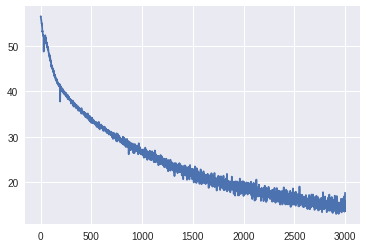

In [329]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))